In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import vmap
import caustics
from IPython.display import HTML
from matplotlib.colors import LogNorm
import corner




In [4]:
! python --version #VS code label wrong. Need <3.11 for mcmc in pylima

Python 3.10.14


In [5]:
cosmology = caustics.FlatLambdaCDM()
sie = caustics.Point(cosmology=cosmology, name='lens')
# src = caustics.Sersic(name='source')
src = caustics.PointSource(name='source')

In [6]:
n_pix = 100
res = 0.05
upsample_factor = 10
theta_x, theta_y = caustics.utils.meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    dtype=torch.float32,
)

In [7]:
class Microlens(caustics.Simulator):
    def __init__(
            self,
            lens,
            src,
            theta_x=None,
            theta_y=None,
            z_s=None,
            lightcurve=False,
            name: str = "sim"
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src
        self.lightcurve = lightcurve

        self.add_param("theta_x", theta_x)
        self.add_param('theta_y', theta_y)
        self.add_param("z_s", z_s)


    def forward(self, params):
        theta_x, theta_y, z_s = self.unpack(params)
        beta_x, beta_y = self.lens.raytrace(theta_x, theta_y, z_s, params)
        brightness = self.src.brightness(beta_x, beta_y, params)

        if self.lightcurve:
            baseline_brightness = self.src.brightness(theta_x, theta_y, params)
            return brightness.mean()/baseline_brightness.mean()

        return brightness


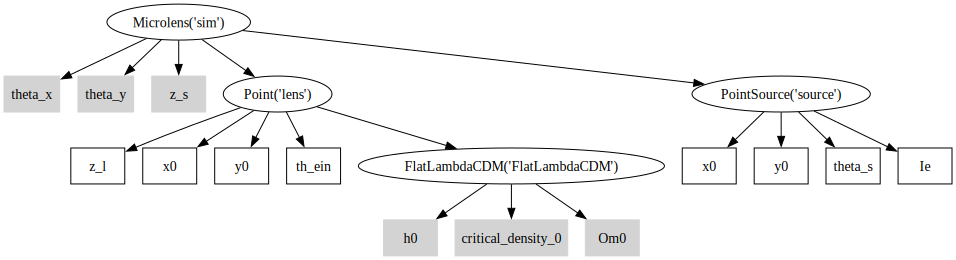

In [8]:
sim = Microlens(sie, src, theta_x=theta_x, theta_y=theta_y, z_s=0.0)
sim.graph(True,True)

In [9]:
sim.x_order

['lens.z_l',
 'lens.x0',
 'lens.y0',
 'lens.th_ein',
 'source.x0',
 'source.y0',
 'source.theta_s',
 'source.Ie']

In [10]:
th_ein = 0.5
rho = 2
x = torch.tensor([
    #    z_l  x0   y0  th_ein x0   y0  theta_s,  Ie
         0.0, 0.0, 0.0, 0.5, 0.0, 0.0, th_ein*rho, 5.0 #Parametrize theta_s in terms of rho
    ])  

In [11]:
B=64 #Batch size
newx = x.repeat(B, 1)
x0s = torch.linspace(-3, 3, B).view(-1, 1)  # Shape is [B, 1]
y0s = torch.zeros_like(x0s)
newx[:,1] = x0s.view(-1)
newx[:,2] = y0s.view(-1)

In [12]:
sim.lightcurve = False #Return images
images = torch.vmap(sim)(newx) 

In [13]:
ts = torch.linspace(-1,1,B).view(-1,1) #Create dummy time variables
sim.lightcurve = True #Return normalized flux counts
magnifications = torch.vmap(sim)(newx) 

In [14]:
# Set up the figure and two subplots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 8))

# Display the first frame of the image in the first subplot
img = ax1.imshow(images[0].numpy(), cmap='cividis', interpolation='bilinear')
ax1.set_title('Image')

# Set up the scatter plot for magnifications in the second subplot
scatter = ax2.scatter(ts[0].item(), magnifications[0].item())
ax2.set_xlim(ts.min().item(), ts.max().item())
ax2.set_ylim(magnifications.min().item()*0.9, magnifications.max().item()*1.1)
ax2.set_xlabel('t')
ax2.set_ylabel('A')

def update(frame):
    """Update function for the animation."""
    # Update the image in the first subplot
    img.set_array(images[frame].numpy())

    # Update the scatter plot in the second subplot
    ax2.clear()  # Clear the previous frame
    ax2.scatter(ts[:frame+1].numpy(), magnifications[:frame+1].numpy())
    ax2.set_xlim(ts.min().item(), ts.max().item())
    ax2.set_ylim(magnifications.min().item()*0.9, magnifications.max().item()*1.1)
    ax2.set_xlabel('t')
    ax2.set_ylabel('A')
    ax2.set_title('Magnification')

    return img, scatter

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

#Save animation
# ani.save("microlensing_animation.gif", writer='pillow', fps=16)  # Adjust 'fps' for the speed

# Display the animation inline
HTML(ani.to_jshtml())

### Fitting the data

In [110]:
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model, FSPLarge_model, FSPL_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.fits import LM_fit, TRF_fit, DE_fit, MCMC_fit
import numpy as np

In [133]:
noise = 0.02*torch.randn_like(magnifications)
noisy_mags = magnifications + noise
# data = np.vstack((ts.view(-1), -1*magnifications, magnifications*0.05)).T
err_mag = 0.05*torch.ones_like(magnifications) #set fixed error for now
data = np.vstack((ts.view(-1), -1*noisy_mags, err_mag)).T

In [134]:
# np.savez('microlensing_dat', data=data)
# data_test = np.load('microlensing_dat.npz')['data']

In [135]:
your_event = event.Event()
your_event.name = 'Simulated Event'
telescope = telescopes.Telescope(name= 'test', light_curve=data, light_curve_names=['time', 'mag', 'err_mag'], light_curve_units=['s', 'mag', 'err_mag'])
your_event.telescopes.append(telescope)
your_event.find_survey('test')
your_event.check_event()
pspl = PSPL_model.PSPLmodel(your_event)
fspl = FSPLarge_model.FSPLargemodel(your_event)
# fspl = FSPL_model.FSPLmodel(your_event)
pspl_fit = LM_fit.LMfit(pspl)
fspl_fit = DE_fit.DEfit(fspl, DE_population_size=10, loss_function='chi2', max_iteration=10000)

check_event  : Everything looks fine...


In [136]:
# #                   t_E  u0   tE  rho
fspl_fit.fit_parameters['rho'][1] = [0.1,10]
fspl_fit.fit_parameters['tE'][1] = (0.1, 2)
guess_parameters = [0.2, 0.3, 0.3, 1]
fspl_fit.model_parameters_guess = guess_parameters

pspl_fit.fit()
fspl_fit.fit()

#Too sensitive to initial guess currently

Selecting test to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [0.015872958860708792, 0.8448220929189584, 0.38787042671561817, 118257688576.0, 118257688576.0]
fit  : Levenberg-Marquardt fit SUCCESS
best_model: [1.1959689306464878, 15.786881276140043, 21406.01735192383, 4795508415064.871, 251758482412.0116]  chi2: 617.6432184552043
DE converge to objective function : f(x) =  9.902782562002479
DE converge to parameters : =  ['0.004404961419003595' '-0.3666489699872857' '0.18107593883357787'
 '1.8495878453516075']
fit  : Differential Evolution fit SUCCESS
best_model: [ 0.00440496 -0.36664897  0.18107594  1.84958785] chi2 9.902782562002479


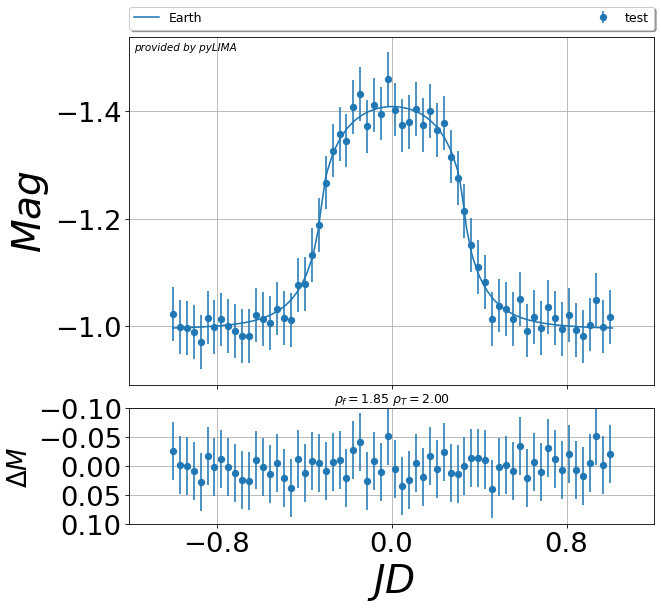

In [137]:
fig = pyLIMA_plots.plot_lightcurves(fspl, fspl_fit.fit_results['best_model'])
# fig = pyLIMA_plots.plot_lightcurves(fspl, guess_parameters)

plt.xlim(-1.2,1.2)
plt.title(r'$\rho_f = {:.2f}$'.format(fspl_fit.fit_results['best_model'][3]) + r' $\rho_T = {:.2f}$'.format(rho))
plt.show()

### MCMC

In [138]:
fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=4, loss_function='chi2')
fspl_mcmc_fit.fit_parameters['rho'][1] = [0.0, 10]
fspl_mcmc_fit.fit_parameters['tE'][1] = (0.1, 2)
# guess_parameters = [0.2, 0.3, 0.3, 2.5]
# fspl_mcmc_fit.model_parameters_guess = guess_parameters

fspl_mcmc_fit.fit()

Selecting test to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [0.015872958860708792, 0.8448220929189584, 0.38787042671561817, 1.8342028102664132]


100%|██████████| 5000/5000 [00:14<00:00, 338.09it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [ 4.04067486e-03  7.62402660e-01  1.50958418e-01  2.31080802e+00
  3.31615226e+11 -1.03081050e+11] chi2 -9.718171485993398


In [139]:
MCMC_results = fspl_mcmc_fit.fit_results['MCMC_chains']
print('Parameters', ' Model', '   Fit', '     Errors')
print('-----------------------------------')
print('t_0:', '        ? ', str(np.median(MCMC_results[1000:, :, 0]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 0]))[:7])
print('u_0:', '        ?', str(np.median(MCMC_results[1000:, :, 1]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 1]))[:7])
print('t_E:', '        ? ', str(np.median(MCMC_results[1000:, :, 2]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 2]))[:7])
print('rho:', '        ? ', str(np.median(MCMC_results[1000:, :, 3]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 3]))[:7])

Parameters  Model    Fit      Errors
-----------------------------------
t_0:         ?  0.00467  0.00610
u_0:         ? -0.0205  0.54810
t_E:         ?  0.15685  0.03756
rho:         ?  2.16524  0.47089


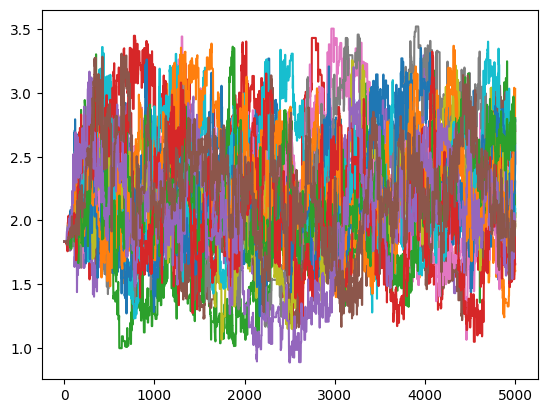

In [140]:
plt.plot(fspl_mcmc_fit.fit_results['MCMC_chains'][:,:,3])
plt.show()

In [141]:
burn_in = 1000
MCMC_results_pruned = MCMC_results[burn_in:, :, :]
reshaped_results = MCMC_results_pruned.reshape(-1, 5)


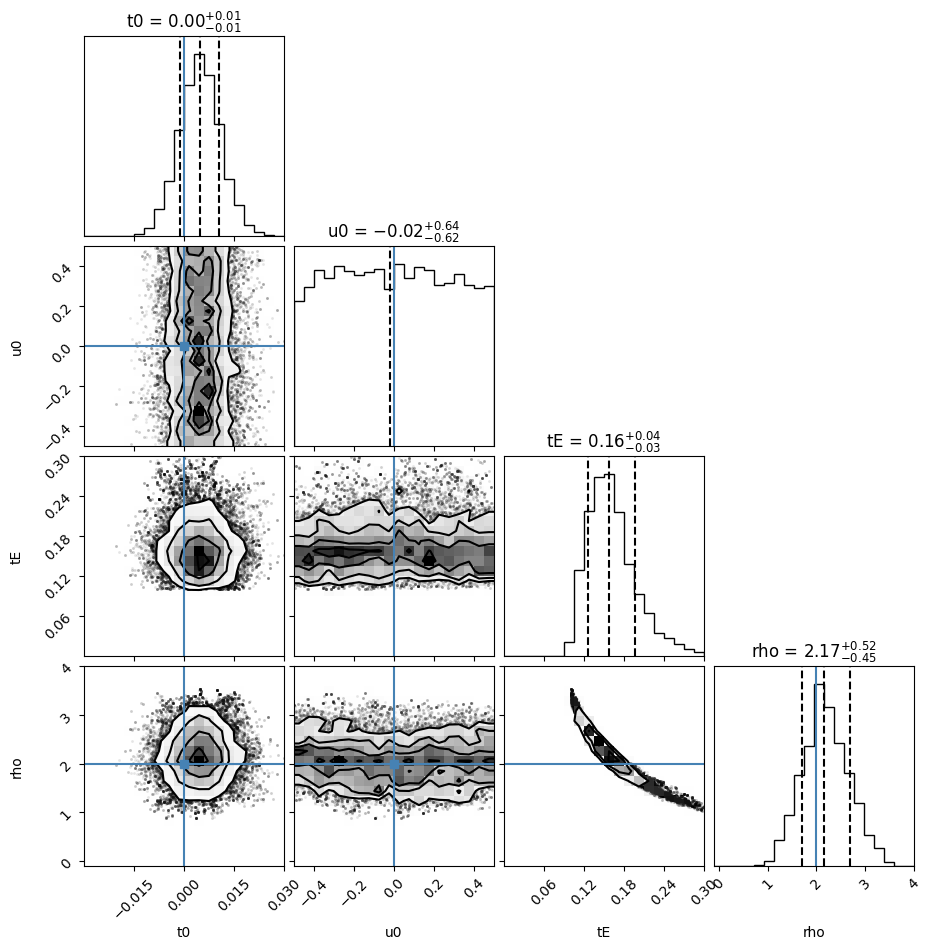

In [142]:
fspl_mcmc_fit.fit_parameters.keys()
figure = corner.corner(reshaped_results[:,0:4], labels=[label for label in fspl_mcmc_fit.fit_parameters.keys()],
                       quantiles=[0.16,0.5, 0.84], 
                       truths=[0.0, 0.0, None, rho], 
                       show_titles=True,
                       range=[(-0.03, 0.03), (-0.5, 0.5), (0, 0.3), (-0.1, 4)]
                       )
